In [1]:
#Importação de libs para ETL
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from skopt import dummy_minimize
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV  
import xgboost as xgb

import pandas as pd
import statistics as sts
import seaborn as sns
import matplotlib.pyplot as plt

import warnings  # biblioteca para ignorar avisos
warnings.filterwarnings("ignore")  # ignorar avisos


In [2]:
dados = pd.read_csv("diabetic_data.csv")
dados


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [3]:
#Remoção de colunas não utilizadas pelo modelo atual
dados = dados.drop(
    columns=['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty'])


In [4]:
# Dados contendo o valor diferente de ? serão substituidos por 1
dados.loc[dados['diag_3'] != '?', 'diag_3'] = 1
# Dados contendo o valor de ? serão substituidos por 0
dados.loc[dados['diag_3'] == '?', 'diag_3'] = 0


In [5]:
# Dados contendo o valor diferente de ? serão substituidos por 1
dados.loc[dados['diag_2'] != '?', 'diag_2'] = 1
# Dados contendo o valor de ? serão substituidos por 0
dados.loc[dados['diag_2'] == '?', 'diag_2'] = 0


In [6]:
# Dados contendo o valor diferente de ? serão substituidos por 1
dados.loc[dados['diag_1'] != '?', 'diag_1'] = 1
# Dados contendo o valor de ? serão substituidos por 0
dados.loc[dados['diag_1'] == '?', 'diag_1'] = 0


In [7]:
#Remoção de linhas contendo Gênero inválido
unknown_gender = dados.loc[dados['gender'] == 'Unknown/Invalid']
dados.drop(unknown_gender.index, inplace=True)


In [8]:
#Remoção de linhas contendo Raça inválido
unknown_gender = dados.loc[dados['race'] == '?']
dados.drop(unknown_gender.index, inplace=True)


In [9]:
# remoção de colunas que não contenham diversidades nos dados.
dados = dados.drop(columns=['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
             'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
             'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
             'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
             'metformin-rosiglitazone', 'metformin-pioglitazone'])


### Exclusão de outliers

In [10]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude


def excluir_outliers(df, nome_coluna):
    # pegar a quantidade de linhas do df
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas


In [11]:
def diagrama_caixa(coluna):
    # linha e coluna
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # mexer no tamanho do tamanho, quando tem uma grafico do lado do outro
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)


def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.distplot(coluna, hist=True)


def grafico_barra(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))


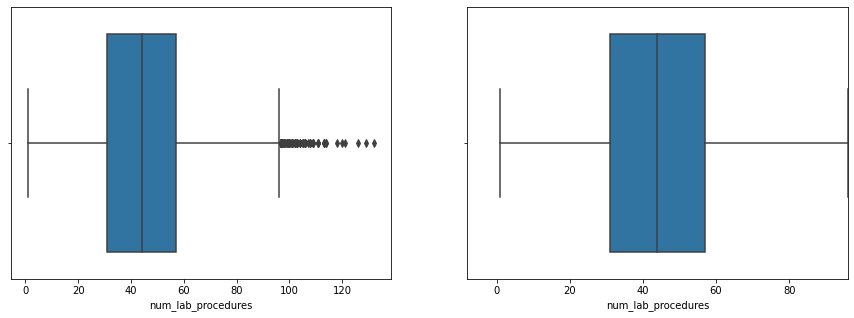

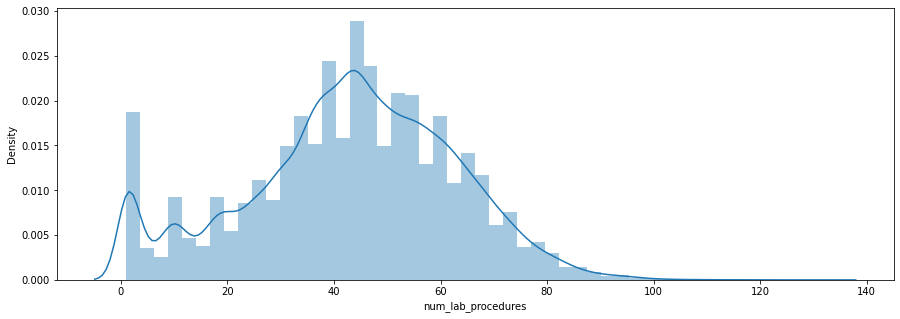

In [12]:
diagrama_caixa(dados['num_lab_procedures'])
histograma(dados['num_lab_procedures'])


In [13]:
dados, linhas_removidas = excluir_outliers(dados, 'num_lab_procedures')
print('{} linha removidas'. format(linhas_removidas))


142 linha removidas


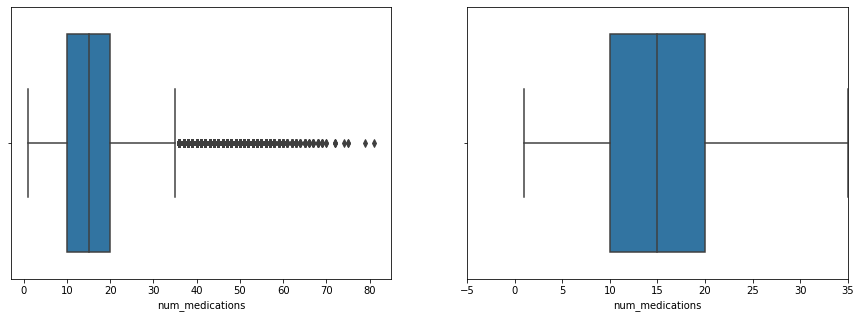

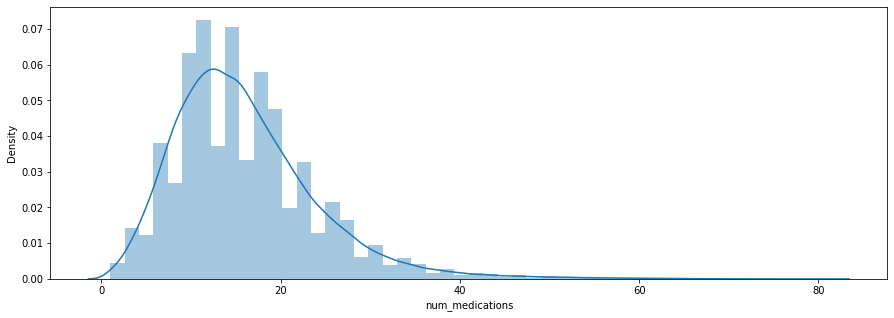

In [14]:
diagrama_caixa(dados['num_medications'])
histograma(dados['num_medications'])


In [15]:
dados, linhas_removidas = excluir_outliers(dados, 'num_medications')
print('{} linha removidas'. format(linhas_removidas))


2455 linha removidas


## Agrupamento de dados

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 12, 14, 15, 16, 17, 21, 20, 18, 22, 19, 27, 24, 26, 23, 25, 33, 35, 36, 29, 34, 39, 42, 28, 37, 38, 40]
0    80809
1    16086
Name: number_outpatient, dtype: int64


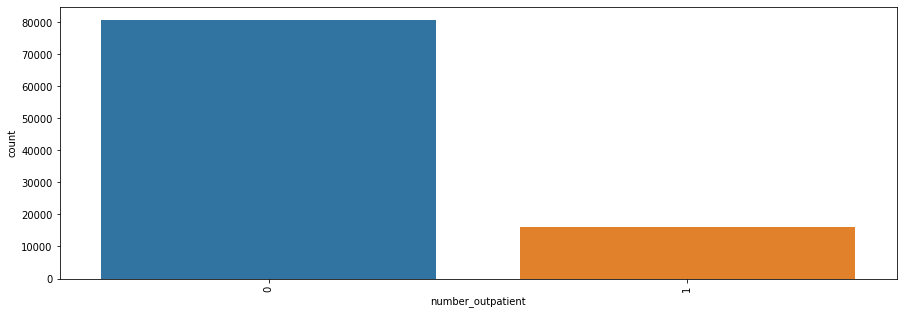

In [16]:
### Dados contendo um valor < 40000 serão substituidos por 1.
tabela = dados['number_outpatient'].value_counts()
colunas_agrupar = []

for tipo in tabela.index:
    if tabela[tipo] < 40000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    dados.loc[dados['number_outpatient']
              == tipo, 'number_outpatient'] = 1

print(dados['number_outpatient'].value_counts())
plt.figure(figsize=(15, 5))
# grafico do seabord para contar
grafico = sns.countplot('number_outpatient', data=dados)
# são as marcações do eixo, em rotação de 90 grau (texto em pé)
grafico.tick_params(axis='x', rotation=90)


In [17]:
# substituição de age
dados.age = dados.age.replace({"[70-80)":75,
                         "[60-70)":65,
                         "[50-60)":55,
                         "[80-90)":85,
                         "[40-50)":45,
                         "[30-40)":35,
                         "[90-100)":95,
                         "[20-30)":25,
                         "[10-20)":15,
                         "[0-10)":5})

[25, 4, 7, 13, 23, 14, 28, 8, 15, 24, 9, 17, 16, 19, 10, 27, 12, 20]
1     57801
3     13269
6     12011
2      5880
18     3474
22     1836
11     1507
5      1117
Name: discharge_disposition_id, dtype: int64


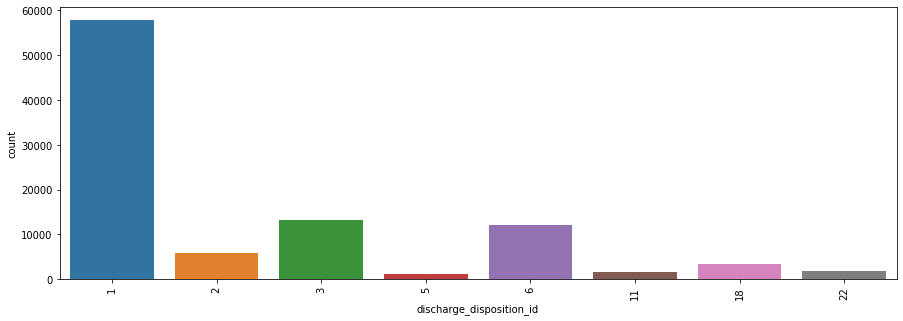

In [19]:
### Dados contendo um valor < 1068 serão substituidos por 1.
tabela = dados['discharge_disposition_id'].value_counts()
colunas_agrupar = []

for tipo in tabela.index:
    if tabela[tipo] < 1068:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    dados.loc[dados['discharge_disposition_id']
              == tipo, 'discharge_disposition_id'] = 2

print(dados['discharge_disposition_id'].value_counts())
plt.figure(figsize=(15, 5))
# grafico do seabord para contar
grafico = sns.countplot('discharge_disposition_id', data=dados)
# são as marcações do eixo, em rotação de 90 grau (texto em pé)
grafico.tick_params(axis='x', rotation=90)


In [20]:
#Substituição de dados categóricos contendo '?' pela moda da respectiva coluna
for col in dados.columns:
    if dados[col].dtypes == 'object':
        column_mis = dados.loc[dados[col] == '?', col]
        if column_mis.size > 0:
            moda = sts.mode(dados[col])
            dados.loc[dados[col] == '?', col] = moda


In [21]:

# Dados contendo o valor diferente de ? serão substituidos por 1
dados.loc[dados['max_glu_serum'] != 'None', 'max_glu_serum'] = 1
# Dados contendo o valor de ? serão substituidos por 0
dados.loc[dados['max_glu_serum'] == 'None', 'max_glu_serum'] = 0


In [22]:
# Dados contendo o valor diferente de ? serão substituidos por 1
dados.loc[dados['A1Cresult'] != 'None', 'A1Cresult'] = 1
# Dados contendo o valor de ? serão substituidos por 0
dados.loc[dados['A1Cresult'] == 'None', 'A1Cresult'] = 0


In [23]:
# Dados contendo o valor diferente de ? serão substituidos por 1
dados.loc[dados['change'] != 'No', 'change'] = 1
# Dados contendo o valor de ? serão substituidos por 0
dados.loc[dados['change'] == 'No', 'change'] = 0


### Correlação das features

<AxesSubplot:>

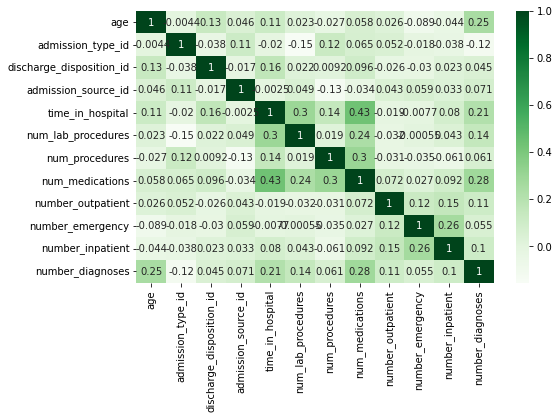

In [24]:
plt.figure(figsize=(8,5))
#annot = True para descrição do graficos
sns.heatmap(dados.corr(),annot=True,cmap='Greens')

In [25]:
# lidando com variáveis categoricas
labelEncoder = preprocessing.LabelEncoder()


In [26]:
# tranformar dados categorias em numericos por meio do LabelEncoder
for col in dados.columns:
    if dados[col].dtypes == 'object' and col != 'readmitted':
        dados[col] = labelEncoder.fit_transform(dados[col])


In [27]:
# Dados diferentes de 0 serão considerados como 1
dados.loc[dados['number_emergency'] != 0, 'number_emergency'] = 1 


In [28]:
# substituindo os valores de readmitted
dados= dados.replace({"NO": 0,
                         "<30":1,
                         ">30":0})

### Treinando modelo

In [30]:
X = dados.drop(columns='readmitted')
y = dados['readmitted']


In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)


In [32]:
# Tempo de execução até 2min.
rf = RandomForestClassifier(
    n_estimators=2000, min_samples_leaf=5, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)
y_pred_rf = rf.predict(X_test)
print("Acurácia:", accuracy_score(y_test, y_pred_rf))


Acurácia: 0.8902267019849324


In [33]:
xgb = xgb.XGBClassifier(n_estimators=5, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)
y_pred_xgb = xgb.predict(X_test)
print("Acurácia:", accuracy_score(y_test, y_pred_xgb))


Acurácia: 0.8899170938112766


[2.43636477e-02 2.86858397e-02 7.53712218e-02 4.01992873e-02
 7.67686357e-02 3.31004986e-02 9.25802572e-02 1.69901339e-01
 6.19852203e-02 1.35351404e-01 1.46905970e-02 1.52579068e-02
 1.19949837e-01 4.30069762e-05 3.29958304e-04 8.01271963e-04
 5.58220309e-02 4.83260169e-03 1.16749199e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.34505419e-02 1.48399763e-02]
Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'examide', 'citoglipton', 'glimepiride-pioglitazone', 'change',
       'diabetesMed'],
      dtype='object')


,0
num_lab_procedures,0.169901
num_medications,0.135351
number_inpatient,0.119950
time_in_hospital,0.092580
discharge_disposition_id,0.076769
age,0.075371
num_procedures,0.061985
number_diagnoses,0.055822
admission_type_id,0.040199
admission_source_id,0.033100


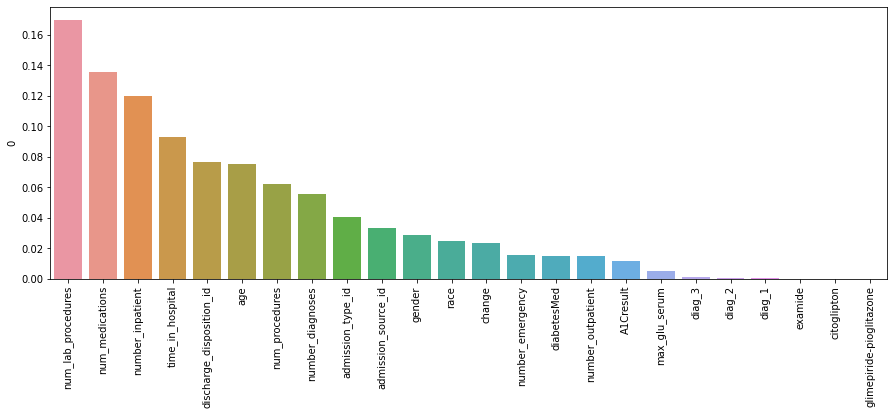

In [34]:
# qual a importancia das features (segue a ordem do x_train)
print(rf.feature_importances_)
print(X_train.columns)

# Juntando as duas listas.
importancia_features = pd.DataFrame(
    rf.feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
# são as marcações do eixo, em rotação de 90 grau (texto em pé)
ax.tick_params(axis='x', rotation=90)


### Métricas de avaliação

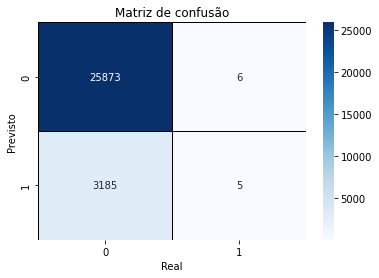

In [35]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues,
            linecolor='black', linewidths=1)
plt.title("Matriz de confusão")
plt.title("Matriz de confusão")
plt.xlabel("Real")
plt.ylabel("Previsto")
plt.show()


In [36]:
print(confusion_matrix(y_test, y_pred_rf))
vn, fp, fn, vp = confusion_matrix(y_test, y_pred_rf).ravel()
print(f"Verdadeiro positivo: {vp}")
print(f"Verdadeiro negativo: {vn}")
print(f"Falso positivo: {fp}")
print(f"Falso negativo: {fn}\n")


[[25873     6]
 [ 3185     5]]
Verdadeiro positivo: 5
Verdadeiro negativo: 25873
Falso positivo: 6
Falso negativo: 3185

